The goal of the Titanic competition is to predict who survived the disaster based on some information about the individual. The competition is described at https://www.kaggle.com/c/titanic/overview

__Data Dictionary__
- Survival: 0 = No, 1 = Yes
- Pclass: Ticket class,, 1st = Upper 2nd = Middle 3rd = Lower
- Sex: sex of the individual
- Age: age in years
- SibSp: The # of siblings / spouses aboard the Titanic Sibling = brother, sister, stepbrother, stepsister Spouse = husband, wife (mistresses and fiancés were ignored)
- Parch: The # of parents / children aboard the Titanic Parent = mother, father Child = daughter, son, stepdaughter, stepson Some children travelled only with a nanny, therefore parch=0 for them.
- Ticket: Ticket number
- Fare: Passenger fare
- Cabin: Cabin number embarked
- Port of Embarkation: C = Cherbourg, Q = Queenstown, S = Southampton

In [683]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter 
import scipy.stats as stats
import string

Loaded the train and test data into pandas data frame. Both the train and test data contain missing values. Train has is missing 177 age values, 687 cabin values and 2 embarked values. Test data is missing 86 age values, 1 fare value and 327 cabin values. The missing values will either need to be imputed (filled in based on training set data) or the rows will need to be removed. Used describe to look into the statistics of the numeric columns. No obvious outliers are observed in the data. 

In [684]:
target_column = ['Survived']
# load in the csv files
test = pd.read_csv('data_files/test.csv')
train = pd.read_csv('data_files/train.csv')
# determine the nans in each column
print('Missing values in train data')
print(train.isna().sum())
print('\nMissing values in test data')
print(test.isna().sum())
print('\nDescribe train data')
print(train.describe())
print('\nDescribe test data')
print(test.describe())

Missing values in train data
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Missing values in test data
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Describe train data
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.00

## Check for invalid values

Created a function to check to see if any of the rows has invalid values (values that should not exist based on the data definition above). 

In [685]:
target_column = 'Survived'

# replace NaNs in the train and test dataframes with the missing value
#train.fillna(missing_value, inplace=True)
#test.fillna(missing_value, inplace=True)

check_values_dict = {'Survived':[0, 1], 
                     'Pclass':[1, 2, 3], 
                     'Sex':['male', 'female'],
                     'Embarked':['C', 'Q', 'S']}

def check_values(df, check_dict):
    return_dict = {}
    for (key, value) in check_dict.items():
        # check if the column exists in pandas
        if key in df.columns:
            # check column and see if there is any invalid values
            temp_bool_series = ~df.loc[~df[key].isnull(), key].isin(value)
            # if invalid values exist for the column. Store the row indices in dictionary
            if temp_bool_series.sum() > 0:
                return_dict[key] = temp_bool_series[temp_bool_series].index
        else:
            print('Column: ' + key + ' does not exist')
    return return_dict

def print_rows_with_invalid(df, invalid_dict):
    for (key, value) in invalid_dict.items():
        print(key + ' is invalid in the following rows')
        print(df.iloc[value])

print('Check if train has any invalid values')
print_rows_with_invalid(train, check_values(train, check_values_dict))
print('Check if test has any invalid values')
print_rows_with_invalid(test, check_values(test, check_values_dict))


Check if train has any invalid values
Check if test has any invalid values
Column: Survived does not exist


## Feature conversion encoding

For most machine learning algorithms, all features must be represented as numbers. Sex is encoded into integers. 

In [686]:
def encode_sex(df):
    df['Sex'] = (df['Sex'].str.lower() == 'male').astype(int)
    return df

train = encode_sex(train)
test = encode_sex(test)

Last name may contain useful information because families may have been more likely to survive or perish together. Following function extracts the last name and title. Last name is assumed to be to the left of the comma. The title may give a hint about age and it is assummed to be between the comma and period. Both are converted to lower case to handle if same word was capitalized differntly in different records.

In [687]:
def parse_name(df):
    split_name_at_comma = df['Name'].str.split(',', n=1, expand=True)
    df['LastName'] = split_name_at_comma.get(0).str.lower()
    split_name_at_period = split_name_at_comma.get(1).str.split('.', n=1, expand=True)
    df['Title'] = split_name_at_period.get(0).str.lower().str.strip()
    df.drop('Name', axis=1, inplace=True)
    return df

# extract name and title
train = parse_name(train)
test = parse_name(test)

Ticket column contains letters and numbers. The column will be broken up into letters and numbers. For the text porition of the ticket number, the string is converted to lower case and the punctuation is stripped from the string. 

In [688]:
# create dictionary of punctuation to remove
punctuation_table = str.maketrans(dict.fromkeys(string.punctuation))

def parse_ticket(df, punctuation_table):
    # split ticket at the first space
    split_ticket_at_space = df['Ticket'].str.split(' ', n=1, expand=True)
    # convert to lower case and remove the punctuation
    temp = split_ticket_at_space.get(0).str.lower().str.translate(punctuation_table)
    df['TicketHeader'] = temp[~temp.str.isnumeric()]
    df['TicketNumber'] = temp[temp.str.isnumeric()]
    df.loc[~temp.str.isnumeric(), 'TicketNumber'] = split_ticket_at_space.get(1)
    df['TicketNumber'] = df['TicketNumber'].astype('int64')
    return df

def extract_numbers_text(df, col):
    # Extract letters from the col, combine into one string and convert to lower case
    df[col + 'Letters'] = df[col].str.findall(r'[A-Za-z]+').str.join('').str.lower()
    # Extract numbers from the col, combine to one string, replace empty strings with NaNs and convert to numeric
    df[col + 'Numbers'] = pd.to_numeric(df[col].str.findall(r'[0-9]+').str.join('').replace('', np.nan))
    #df.drop(col, axis=1, inplace=True)
    return df
    

train = extract_numbers_text(train, 'Ticket')
test = extract_numbers_text(test, 'Ticket')

train = extract_numbers_text(train, 'Cabin')
test = extract_numbers_text(test, 'Cabin')


Some individuals have multiple cabins. For example, cabin = 'C1 C2 C3' would lead to an extracted text = 'ccc'. The following function extracts only the unique characters. For the example above, the extracted text would become 'c'.

In [689]:
def create_set_string(string):
    if type(string) == str:
        string = ''.join(sorted(list(set(string))))
    return string
 
train['CabinLetters'] = train['CabinLetters'].apply(create_set_string)
test['CabinLetters'] = test['CabinLetters'].apply(create_set_string)



Looked at the percentage of people that were on the different decks. The percentage is low for all decks, which means the deck must be imputed from the other features in order for this to be a useful feature. 

In [690]:
print('Percentage of records in train')
print(train['CabinLetters'].value_counts()/len(train)*100)
print('Percentage of records in test')
print(test['CabinLetters'].value_counts()/len(train)*100)

Percentage of records in train
c     6.621773
b     5.274972
d     3.703704
e     3.591470
a     1.683502
f     1.010101
g     0.448934
fg    0.336700
ef    0.112233
t     0.112233
Name: CabinLetters, dtype: float64
Percentage of records in test
c     3.928171
b     2.020202
d     1.459035
e     1.010101
a     0.785634
f     0.561167
ef    0.224467
g     0.112233
fg    0.112233
Name: CabinLetters, dtype: float64


## Impute Missing Data

The columns age, cabin, embarked and fare have NaN values. Exploratory data anlysis is performed to see the correlation between parameters with goal of using a different parameter to guess what the missing value should be.

Train has is missing 177 age values, 687 cabin values and 2 embarked values. Test data is missing 86 age values, 1 fare value and 327 cabin values.



### Fare 

Fare and Pclass should be correlated. Higher fare with better class (lower number). Histogram was created to look for the correlation. Pclass = 1 has higher ticket price than Pclass = 2 and 3. The fare is non gaussin for the different Pclasses

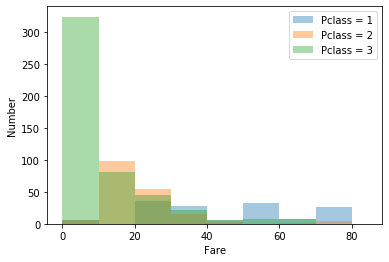

In [691]:
def multi_hist(df, value_col, hue_col, bins):
    unique_values = sorted(df[hue_col].unique())
    for value in unique_values:
        selected_entries = df[df[hue_col] == value]
        label = hue_col + ' = '+ str(value)
        sns.distplot(selected_entries[value_col].dropna(),  kde=False, label=label, bins=bins)
    plt.legend()
    plt.xlabel(value_col)
    plt.ylabel('Number')
    plt.show()
    return None

bins = np.arange(0, 90, 10)
multi_hist(train, 'Fare', 'Pclass', bins=bins)
#Note: There is a new function called sns.histogram that should be released soon which will do the above better

A function is created to look at the emperical cummulative distribution function (ECDF). ECDF is another way to look at the distribution of the data. From the ECDF, there is large difference in the distribution for fare of pclass = 1 and the other pclasses. The difference between pclass = 2 and pclass = 3 is small. 

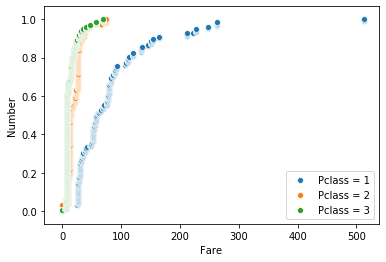

             mean   median        std
Pclass                               
1       84.154687  60.2875  78.380373
2       20.662183  14.2500  13.417399
3       13.675550   8.0500  11.778142


In [692]:
def multi_ecdf(df, value_col, hue_col):
    unique_values = sorted(df[hue_col].unique())
    for value in unique_values:
        selected_entries = df[df[hue_col] == value]
        label = hue_col + ' = '+ str(value)
        """ Compute ECDF """
        x = np.sort(selected_entries[value_col].dropna())
        n = x.size
        y = np.arange(1, n+1) / n
        sns.scatterplot(x, y, label=label)
    plt.legend()
    plt.xlabel(value_col)
    plt.ylabel('Number')
    plt.show()
    return None

multi_ecdf(train, 'Fare', 'Pclass')

print(train.groupby('Pclass')['Fare'].agg([np.mean, np.median, np.std]))

The missing fare will be imputed by using the median fare from train for the given pclass. This reduces the impact of the outliers observed in Pclass = 1.

In [693]:
def impute_fare(train, test):
    median_fare_by_class = train.groupby('Pclass')['Fare'].agg(np.median).round(2)
    for p_class in median_fare_by_class.index:
        mask_train = train['Fare'].isna() & (train['Pclass'] == p_class)
        mask_test = test['Fare'].isna() & (test['Pclass'] == p_class)
        train.loc[mask_train, 'Fare'] = median_fare_by_class[p_class]
        test.loc[mask_test, 'Fare'] = median_fare_by_class[p_class]
    return train, test

train, test = impute_fare(train, test)

### Age

Age may be correlated with the title of the person (ex. Mr., Mrs., ....). In order to determine this, histograms were created for the different titles. Before creating the historam any title with very low percentage is merged into a new category callled other. 

In [694]:
merge_below_percent = 4
title_precent = train['Title'].value_counts() / train['Title'].value_counts().sum() * 100
print(title_precent)
merge_index = title_precent[title_precent < merge_below_percent].index
train.loc[train['Title'].isin(merge_index), 'Title'] = 'other'
print(train['Title'].value_counts() / train['Title'].value_counts().sum() * 100)

mr              58.024691
miss            20.426487
mrs             14.029181
master           4.489338
dr               0.785634
rev              0.673401
major            0.224467
col              0.224467
mlle             0.224467
sir              0.112233
don              0.112233
lady             0.112233
mme              0.112233
capt             0.112233
jonkheer         0.112233
the countess     0.112233
ms               0.112233
Name: Title, dtype: float64
mr        58.024691
miss      20.426487
mrs       14.029181
master     4.489338
other      3.030303
Name: Title, dtype: float64


Create an ECDF on the age to better determine if titlte can be used to impute age. Master can be used if the individual is under 10. The other titles have wide distributions.

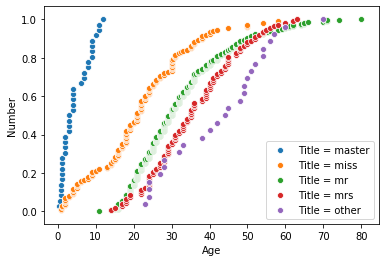

             mean  median        std
Title                               
master   4.574167     3.5   3.619872
miss    21.773973    21.0  12.990292
mr      32.368090    30.0  12.708793
mrs     35.898148    35.0  11.433628
other   42.384615    44.5  13.200233


In [695]:
multi_ecdf(train, 'Age', 'Title')
print(train.groupby('Title')['Age'].agg([np.mean, np.median, np.std]))

### Cabin

Check if ticket number can be used to fill in cabin. Unfortunately, only 10 ticket numbers have at least one null and at least one not null value. Looking at some of the entries, those tickets are sold to people with different last name. Therefore, cabin cannot be imputed from ticket number 

In [696]:
# list of ticket numbers that have a not null cabin
ticket_numbers_not_null = train[train['Cabin'].notnull()]['TicketNumbers'].unique()
# list of ticket numbers that have a null cabin
ticket_numbers_null = train[train['Cabin'].isna()]['TicketNumbers'].unique()
# create a list of ticket numbers with at least one nul value and one not null value
common_ticket_numbers = sorted(list(set(ticket_numbers_not_null) & set(ticket_numbers_null)))
print(len(common_ticket_numbers))
print(common_ticket_numbers)
print(train[train['TicketNumbers'] == 113781])

10
[3.0, 2668.0, 17421.0, 17755.0, 17757.0, 17760.0, 17761.0, 19877.0, 36928.0, 113781.0]
     PassengerId  Survived  Pclass  Sex    Age  SibSp  Parch  Ticket    Fare  \
297          298         0       1    0   2.00      1      2  113781  151.55   
305          306         1       1    1   0.92      1      2  113781  151.55   
498          499         0       1    0  25.00      1      2  113781  151.55   
708          709         1       1    0  22.00      0      0  113781  151.55   

       Cabin Embarked LastName   Title TicketLetters  TicketNumbers  \
297  C22 C26        S  allison    miss                     113781.0   
305  C22 C26        S  allison  master                     113781.0   
498  C22 C26        S  allison     mrs                     113781.0   
708      NaN        S  cleaver    miss                     113781.0   

    CabinLetters  CabinNumbers  
297            c        2226.0  
305            c        2226.0  
498            c        2226.0  
708          NaN     

Check if last name can be used to fill in cabin. Unfortunately, only 14 last nameshave at least one null and at least one not null value. Looking at some of the entries, those last names correspond to tickets with very different fares and classes. Therfore, last name cannot be used to determine cabin.

In [697]:
# list of ticket numbers that have a not null cabin
last_name_numbers_not_null = train[train['Cabin'].notnull()]['LastName'].unique()
# list of ticket numbers that have a null cabin
last_name_numbers_null = train[train['Cabin'].isna()]['LastName'].unique()
# create a list of ticket numbers with at least one nul value and one not null value
common_last_name = sorted(list(set(last_name_numbers_not_null) & set(last_name_numbers_null)))
print(len(common_last_name))
print(common_last_name)
print(train[train['LastName'] == 'carter'])


14
['allen', 'brown', 'carlsson', 'carter', 'daly', 'flynn', 'harper', 'harris', 'hoyt', 'keane', 'peter', 'smith', 'webber', 'wick']
     PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch  Ticket   Fare  \
249          250         0       2    1  54.0      1      0  244252   26.0   
390          391         1       1    1  36.0      1      2  113760  120.0   
435          436         1       1    0  14.0      1      2  113760  120.0   
763          764         1       1    0  36.0      1      2  113760  120.0   
802          803         1       1    1  11.0      1      2  113760  120.0   
854          855         0       2    0  44.0      1      0  244252   26.0   

       Cabin Embarked LastName   Title TicketLetters  TicketNumbers  \
249      NaN        S   carter   other                     244252.0   
390  B96 B98        S   carter      mr                     113760.0   
435  B96 B98        S   carter    miss                     113760.0   
763  B96 B98        S   carter     

In [698]:
print(train.groupby('CabinLetters')['Survived'].agg(np.mean))

CabinLetters
a     0.466667
b     0.744681
c     0.593220
d     0.757576
e     0.750000
ef    1.000000
f     0.777778
fg    0.000000
g     0.500000
t     0.000000
Name: Survived, dtype: float64


In [699]:
print(train.groupby('Title')['Survived'].agg(np.mean))

Title
master    0.575000
miss      0.697802
mr        0.156673
mrs       0.792000
other     0.444444
Name: Survived, dtype: float64


In [700]:
print(mask_train_not_null.to_numpy())

[[2 1 1 ... 17599.0 'c' 85.0]
 [4 1 1 ... 113803.0 'c' 123.0]
 [7 0 1 ... 17463.0 'e' 46.0]
 ...
 [880 1 1 ... 11767.0 'c' 50.0]
 [888 1 1 ... 112053.0 'b' 42.0]
 [890 1 1 ... 111369.0 'c' 148.0]]


Feature Selection

In [701]:
correlation_matrix_male_survived = pd.crosstab(train['Survived'], train['Sex'], rownames=['Survived'], colnames=['Sex'])
print(correlation_matrix_male_survived)
print(train.groupby('Sex')['Survived'].agg(np.mean))
#Male is a good feature

Sex         0    1
Survived          
0          81  468
1         233  109
Sex
0    0.742038
1    0.188908
Name: Survived, dtype: float64


In [702]:
correlation_matrix_pclass_survived = pd.crosstab(train['Survived'], train['Pclass'], rownames=['Survived'], colnames=['Pclass'])
print(correlation_matrix_pclass_survived)
print(train.groupby('Pclass')['Survived'].agg(np.mean))
#Pclass is a good feature

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


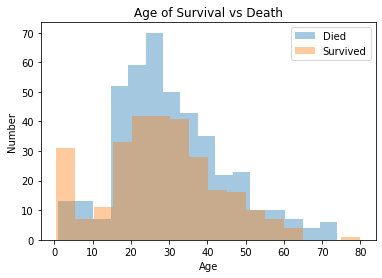

In [703]:
#age_bins = list(range(0,100,10))
df = train[train['Survived'] == 0]
sns.distplot(df['Age'].dropna(),  kde=False, label='Died')
df = train[train['Survived'] == 1]
sns.distplot(df['Age'].dropna(),  kde=False, label='Survived')
plt.legend()
plt.title('Age of Survival vs Death')
plt.xlabel('Age')
plt.ylabel('Number')
plt.show()

In [704]:
# look into age affects survival
train['AgeDecade'] = (train['Age'] / 10).apply(np.floor)
trained_grouped_by_age_decade = train.groupby('AgeDecade')
print(trained_grouped_by_age_decade['Survived'].agg(np.mean))
print(trained_grouped_by_age_decade['Survived'].count())

AgeDecade
0.0    0.612903
1.0    0.401961
2.0    0.350000
3.0    0.437126
4.0    0.382022
5.0    0.416667
6.0    0.315789
7.0    0.000000
8.0    1.000000
Name: Survived, dtype: float64
AgeDecade
0.0     62
1.0    102
2.0    220
3.0    167
4.0     89
5.0     48
6.0     19
7.0      6
8.0      1
Name: Survived, dtype: int64


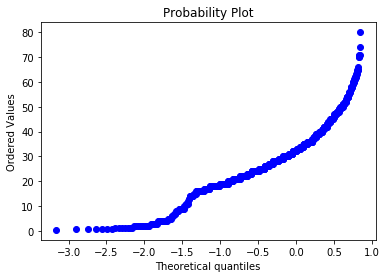

In [705]:
stats.probplot(train["Age"], dist="norm", plot=plt)
plt.show()
# data does not have normal distribution because not on 45 degree line

In [706]:
print(train.groupby('SibSp')['Survived'].agg(np.mean))
print(train.groupby('SibSp')['Survived'].count())

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64
SibSp
0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: Survived, dtype: int64


In [707]:
print(train.groupby('Parch')['Survived'].agg(np.mean))
print(train.groupby('Parch')['Survived'].count())

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64
Parch
0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: Survived, dtype: int64


In [708]:
print(train.groupby('Embarked')['Survived'].agg(np.mean))
print(train.groupby('Embarked')['Survived'].count())
# suprisingly this looks like a good feature

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64
Embarked
C    168
Q     77
S    644
Name: Survived, dtype: int64


Cabin
A10    0.0
A14    0.0
A16    1.0
A19    0.0
A20    1.0
      ... 
F33    1.0
F38    0.0
F4     1.0
G6     0.5
T      0.0
Name: Survived, Length: 147, dtype: float64
Cabin
A10    1
A14    1
A16    1
A19    1
A20    1
      ..
F33    3
F38    1
F4     2
G6     4
T      1
Name: Survived, Length: 147, dtype: int64


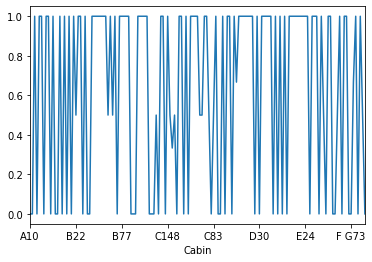

In [709]:
survival_by_cabin = train.groupby('Cabin')['Survived']
print(survival_by_cabin.agg(np.mean))
print(survival_by_cabin.count())
#print(survival_by_cabin.loc[survival_by_cabin.count() > 1])
survival_by_cabin.agg(np.mean).plot()
plt.show()


In [710]:
def most_frequent(input_list):
    if not input_list:
        return ''
    else:
        occurence_count = Counter(input_list)
        return occurence_count.most_common(1)[0][0] 

In [711]:
print(most_frequent(['A', 'B', 'A']))
print(most_frequent(['']))

A



    PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch    Ticket  \
3             4         1       1    0  35.0      1      0    113803   
10           11         1       3    0   4.0      1      1   PP 9549   
27           28         0       1    1  19.0      3      2     19950   
52           53         1       1    0  49.0      1      0  PC 17572   
62           63         0       1    1  45.0      1      0     36973   

        Fare        Cabin Embarked   LastName Title TicketLetters  \
3    53.1000         C123        S   futrelle   mrs                 
10   16.7000           G6        S  sandstrom  miss            pp   
27  263.0000  C23 C25 C27        S    fortune    mr                 
52   76.7292          D33        C     harper   mrs            pc   
62   83.4750          C83        S     harris    mr                 

    TicketNumbers CabinLetters  CabinNumbers  AgeDecade  
3        113803.0            c         123.0        3.0  
10         9549.0            g      

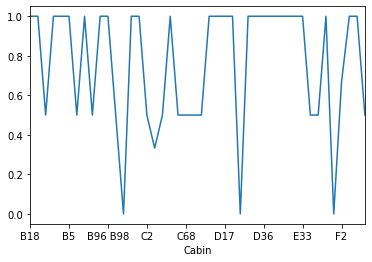

In [712]:
# Cabin, Embarked, and age have missing values
# find cabins with more than one person
cabin_more_than_one_person = train[train['Cabin'].duplicated(keep=False)].dropna()
print(cabin_more_than_one_person.head())
cabin_more_than_one_person.groupby('Cabin')['Survived'].agg(np.mean).plot()
plt.show()

In [713]:
survival_by_cabin_letter = train.groupby('CabinLetter')['Survived']
print(survival_by_cabin_letter.agg(np.mean))
print(survival_by_cabin_letter.count())
#print(survival_by_cabin.loc[survival_by_cabin.count() > 1])
survival_by_cabin_letter.agg(np.mean).plot()
plt.show()

KeyError: 'CabinLetter'

In [ ]:
#age_bins = list(range(0,100,10))
sns.distplot(train['Fare'].dropna(),  kde=False, label='Died')
plt.xlabel('Fare')
plt.ylabel('Number')
plt.show()

In [ ]:
#age_bins = list(range(0,100,10))
df = train[train['Survived'] == 0]
sns.distplot(df['Fare'].dropna(),  kde=False, label='Died')
df = train[train['Survived'] == 1]
sns.distplot(df['Fare'].dropna(),  kde=False, label='Survived')
plt.legend()
plt.title('Fare of Survival vs Death')
plt.xlabel('Fare')
plt.ylabel('Number')
plt.show()

In [ ]:
sns.scatterplot(x=train['Fare'], y=train['CabinLetter'], hue=train['Survived'])
plt.plot()

In [ ]:
print(train.head(20))

In [ ]:
median_fare_by_class = train.groupby('Pclass')['Fare'].agg(np.median).round(2)
mask = test['Fare'].isna() & (test['Pclass'] == 3)
#tst = test.mask(test['Fare'].isnull() & (test['Pclass'] == 3), median_fare_by_class[3])
print(mask.iloc[152])
#tst2 = test.copy()
#tst2.loc[mask, 'Fare'] = median_fare_by_class[3]
test.loc[mask, 'Fare'] = median_fare_by_class[3]
print(test.iloc[151:154])
